In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.models import Model
from keras.layers import *
from keras.layers.merge import concatenate

In [0]:
def one_by_one_cnn(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    
    return one_by_one

In [0]:
def one_by_three_cnn(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    
    return one_by_one

In [0]:
def yoon_kim_pool(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = MaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = MaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = MaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = MaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [0]:
def yoon_kim_feature_extractor(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [12]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
convBlocks = 2

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Average()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

preprocess = one_by_one_cnn(300, embedding_dropout)
preprocess = one_by_one_cnn(300, preprocess)
preprocess = one_by_one_cnn(300, preprocess)

block = preprocess
for currentBlock in range(convBlocks):
  filters = 128 * (2 + currentBlock)
  block = one_by_three_cnn(filters, block)
  if(currentBlock < convBlocks-1):
    block = yoon_kim_pool(filters, block)
  
features = yoon_kim_feature_extractor(512, block)

dense_1 = Dense(256, activation = 'elu')(features)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(256, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

output_layer = Dense(6, activation='sigmoid')(dense_2_dropout)

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [13]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21312/102124 [=====>........................] - ETA: 11:36 - loss: 0.1846 - acc: 0.9286

102112/102124 [============================>.] - ETA: 0s - loss: 0.0929 - acc: 0.9657

102124/102124 [==============================] - 921s 9ms/step - loss: 0.0929 - acc: 0.9657 - val_loss: 0.0532 - val_acc: 0.9800
Epoch 2/32
 10144/102124 [=>............................] - ETA: 12:48 - loss: 0.0644 - acc: 0.9762

102112/102124 [============================>.] - ETA: 0s - loss: 0.0619 - acc: 0.9775

102124/102124 [==============================] - 916s 9ms/step - loss: 0.0619 - acc: 0.9775 - val_loss: 0.0478 - val_acc: 0.9822
roc-auc: 0.9764 - roc-auc_val: 0.9746                                                                                                    
Epoch 3/32
  8672/102124 [=>............................] - ETA: 13:00 - loss: 0.0579 - acc: 0.9782

102112/102124 [============================>.] - ETA: 0s - loss: 0.0574 - acc: 0.9791

102124/102124 [==============================] - 915s 9ms/step - loss: 0.0574 - acc: 0.9791 - val_loss: 0.0491 - val_acc: 0.9815
Epoch 4/32
 10144/102124 [=>............................] - ETA: 12:48 - loss: 0.0526 - acc: 0.9809

102112/102124 [============================>.] - ETA: 0s - loss: 0.0552 - acc: 0.9797

102124/102124 [==============================] - 915s 9ms/step - loss: 0.0552 - acc: 0.9798 - val_loss: 0.0498 - val_acc: 0.9817

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00036602141335606575.
roc-auc: 0.9771 - roc-auc_val: 0.9746                                                                                                    
Epoch 5/32
  5920/102124 [>.............................] - ETA: 13:23 - loss: 0.0503 - acc: 0.9817

102112/102124 [============================>.] - ETA: 0s - loss: 0.0534 - acc: 0.9803

102124/102124 [==============================] - 915s 9ms/step - loss: 0.0533 - acc: 0.9803 - val_loss: 0.0512 - val_acc: 0.9808
Epoch 6/32
 10144/102124 [=>............................] - ETA: 12:47 - loss: 0.0536 - acc: 0.9809

102112/102124 [============================>.] - ETA: 0s - loss: 0.0520 - acc: 0.9809

102124/102124 [==============================] - 915s 9ms/step - loss: 0.0520 - acc: 0.9809 - val_loss: 0.0529 - val_acc: 0.9817
roc-auc: 0.9792 - roc-auc_val: 0.9755                                                                                                    
Epoch 7/32
  8672/102124 [=>............................] - ETA: 13:00 - loss: 0.0525 - acc: 0.9804

102112/102124 [============================>.] - ETA: 0s - loss: 0.0508 - acc: 0.9813

102124/102124 [==============================] - 915s 9ms/step - loss: 0.0508 - acc: 0.9813 - val_loss: 0.0510 - val_acc: 0.9818
Epoch 8/32
 10144/102124 [=>............................] - ETA: 12:48 - loss: 0.0524 - acc: 0.9803

102112/102124 [============================>.] - ETA: 0s - loss: 0.0497 - acc: 0.9817

102124/102124 [==============================] - 915s 9ms/step - loss: 0.0497 - acc: 0.9817 - val_loss: 0.0475 - val_acc: 0.9828
roc-auc: 0.9809 - roc-auc_val: 0.9764                                                                                                    
Epoch 9/32
  8672/102124 [=>............................] - ETA: 13:01 - loss: 0.0528 - acc: 0.9805

102112/102124 [============================>.] - ETA: 0s - loss: 0.0493 - acc: 0.9816

102124/102124 [==============================] - 915s 9ms/step - loss: 0.0493 - acc: 0.9816 - val_loss: 0.0481 - val_acc: 0.9825
Epoch 10/32
 10112/102124 [=>............................] - ETA: 12:48 - loss: 0.0467 - acc: 0.9832

102112/102124 [============================>.] - ETA: 0s - loss: 0.0488 - acc: 0.9818

102124/102124 [==============================] - 914s 9ms/step - loss: 0.0488 - acc: 0.9818 - val_loss: 0.0462 - val_acc: 0.9825
roc-auc: 0.9816 - roc-auc_val: 0.9767                                                                                                    
Epoch 11/32
  8672/102124 [=>............................] - ETA: 13:02 - loss: 0.0489 - acc: 0.9814

102112/102124 [============================>.] - ETA: 0s - loss: 0.0480 - acc: 0.9819

102124/102124 [==============================] - 917s 9ms/step - loss: 0.0480 - acc: 0.9819 - val_loss: 0.0460 - val_acc: 0.9832
Epoch 12/32
 10112/102124 [=>............................] - ETA: 12:49 - loss: 0.0452 - acc: 0.9831

102112/102124 [============================>.] - ETA: 0s - loss: 0.0474 - acc: 0.9821

102124/102124 [==============================] - 917s 9ms/step - loss: 0.0474 - acc: 0.9821 - val_loss: 0.0457 - val_acc: 0.9829
roc-auc: 0.9823 - roc-auc_val: 0.9773                                                                                                    
Epoch 13/32
  8672/102124 [=>............................] - ETA: 13:02 - loss: 0.0530 - acc: 0.9801

102112/102124 [============================>.] - ETA: 0s - loss: 0.0470 - acc: 0.9823

102124/102124 [==============================] - 915s 9ms/step - loss: 0.0470 - acc: 0.9823 - val_loss: 0.0464 - val_acc: 0.9830
Epoch 14/32
 10112/102124 [=>............................] - ETA: 12:48 - loss: 0.0469 - acc: 0.9822

102112/102124 [============================>.] - ETA: 0s - loss: 0.0467 - acc: 0.9824

102124/102124 [==============================] - 916s 9ms/step - loss: 0.0467 - acc: 0.9824 - val_loss: 0.0460 - val_acc: 0.9833
roc-auc: 0.9833 - roc-auc_val: 0.9776                                                                                                    
Epoch 15/32
  8672/102124 [=>............................] - ETA: 13:00 - loss: 0.0450 - acc: 0.9829

102112/102124 [============================>.] - ETA: 0s - loss: 0.0462 - acc: 0.9826

102124/102124 [==============================] - 914s 9ms/step - loss: 0.0462 - acc: 0.9826 - val_loss: 0.0461 - val_acc: 0.9834

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0001166291258414276.
Epoch 16/32
  8000/102124 [=>............................] - ETA: 13:05 - loss: 0.0443 - acc: 0.9834

102112/102124 [============================>.] - ETA: 0s - loss: 0.0458 - acc: 0.9829

102124/102124 [==============================] - 915s 9ms/step - loss: 0.0458 - acc: 0.9829 - val_loss: 0.0456 - val_acc: 0.9829
roc-auc: 0.9835 - roc-auc_val: 0.9771                                                                                                    
Epoch 17/32
  8672/102124 [=>............................] - ETA: 13:00 - loss: 0.0465 - acc: 0.9827

102112/102124 [============================>.] - ETA: 0s - loss: 0.0456 - acc: 0.9829

102124/102124 [==============================] - 915s 9ms/step - loss: 0.0456 - acc: 0.9829 - val_loss: 0.0454 - val_acc: 0.9829
Epoch 18/32
 10112/102124 [=>............................] - ETA: 12:48 - loss: 0.0448 - acc: 0.9822

102112/102124 [============================>.] - ETA: 0s - loss: 0.0453 - acc: 0.9830

102124/102124 [==============================] - 914s 9ms/step - loss: 0.0453 - acc: 0.9830 - val_loss: 0.0466 - val_acc: 0.9826
roc-auc: 0.9839 - roc-auc_val: 0.9775                                                                                                    
Epoch 19/32
  8672/102124 [=>............................] - ETA: 12:59 - loss: 0.0461 - acc: 0.9830

102112/102124 [============================>.] - ETA: 0s - loss: 0.0453 - acc: 0.9828

102124/102124 [==============================] - 914s 9ms/step - loss: 0.0453 - acc: 0.9828 - val_loss: 0.0456 - val_acc: 0.9830
Epoch 20/32
 10112/102124 [=>............................] - ETA: 12:47 - loss: 0.0462 - acc: 0.9824

102112/102124 [============================>.] - ETA: 0s - loss: 0.0449 - acc: 0.9830

102124/102124 [==============================] - 913s 9ms/step - loss: 0.0449 - acc: 0.9830 - val_loss: 0.0444 - val_acc: 0.9835
roc-auc: 0.9843 - roc-auc_val: 0.9774                                                                                                    
Epoch 21/32
  8672/102124 [=>............................] - ETA: 12:58 - loss: 0.0443 - acc: 0.9838

102112/102124 [============================>.] - ETA: 0s - loss: 0.0447 - acc: 0.9830

102124/102124 [==============================] - 914s 9ms/step - loss: 0.0447 - acc: 0.9829 - val_loss: 0.0441 - val_acc: 0.9834
Epoch 22/32
 10112/102124 [=>............................] - ETA: 12:48 - loss: 0.0441 - acc: 0.9833

102112/102124 [============================>.] - ETA: 0s - loss: 0.0444 - acc: 0.9832

102124/102124 [==============================] - 914s 9ms/step - loss: 0.0444 - acc: 0.9832 - val_loss: 0.0448 - val_acc: 0.9830
roc-auc: 0.9853 - roc-auc_val: 0.9778                                                                                                    
Epoch 23/32
  8672/102124 [=>............................] - ETA: 12:59 - loss: 0.0447 - acc: 0.9828

102112/102124 [============================>.] - ETA: 0s - loss: 0.0443 - acc: 0.9833

102124/102124 [==============================] - 914s 9ms/step - loss: 0.0444 - acc: 0.9833 - val_loss: 0.0453 - val_acc: 0.9831
Epoch 24/32
 10112/102124 [=>............................] - ETA: 12:48 - loss: 0.0438 - acc: 0.9837

102112/102124 [============================>.] - ETA: 0s - loss: 0.0443 - acc: 0.9832

102124/102124 [==============================] - 914s 9ms/step - loss: 0.0443 - acc: 0.9832 - val_loss: 0.0460 - val_acc: 0.9830
roc-auc: 0.9841 - roc-auc_val: 0.977                                                                                                    
Epoch 25/32
  8672/102124 [=>............................] - ETA: 12:59 - loss: 0.0443 - acc: 0.9834

102112/102124 [============================>.] - ETA: 0s - loss: 0.0439 - acc: 0.9833

102124/102124 [==============================] - 914s 9ms/step - loss: 0.0439 - acc: 0.9833 - val_loss: 0.0446 - val_acc: 0.9832
Epoch 26/32
 10112/102124 [=>............................] - ETA: 12:48 - loss: 0.0427 - acc: 0.9834

102112/102124 [============================>.] - ETA: 0s - loss: 0.0439 - acc: 0.9832

102124/102124 [==============================] - 915s 9ms/step - loss: 0.0439 - acc: 0.9832 - val_loss: 0.0456 - val_acc: 0.9834

Epoch 00026: ReduceLROnPlateau reducing learning rate to 3.7162721127970144e-05.
roc-auc: 0.9839 - roc-auc_val: 0.9764                                                                                                    
Epoch 27/32
  5920/102124 [>.............................] - ETA: 13:22 - loss: 0.0458 - acc: 0.9823

102112/102124 [============================>.] - ETA: 0s - loss: 0.0435 - acc: 0.9833

102124/102124 [==============================] - 915s 9ms/step - loss: 0.0435 - acc: 0.9834 - val_loss: 0.0448 - val_acc: 0.9834
Epoch 28/32
 10112/102124 [=>............................] - ETA: 12:49 - loss: 0.0436 - acc: 0.9835

102112/102124 [============================>.] - ETA: 0s - loss: 0.0434 - acc: 0.9836

102124/102124 [==============================] - 915s 9ms/step - loss: 0.0434 - acc: 0.9836 - val_loss: 0.0444 - val_acc: 0.9833
roc-auc: 0.9864 - roc-auc_val: 0.9783                                                                                                    
Epoch 29/32
  8672/102124 [=>............................] - ETA: 12:59 - loss: 0.0421 - acc: 0.9840

102112/102124 [============================>.] - ETA: 0s - loss: 0.0434 - acc: 0.9834

102124/102124 [==============================] - 915s 9ms/step - loss: 0.0434 - acc: 0.9834 - val_loss: 0.0442 - val_acc: 0.9835
Epoch 30/32
 10112/102124 [=>............................] - ETA: 12:48 - loss: 0.0442 - acc: 0.9830

102112/102124 [============================>.] - ETA: 0s - loss: 0.0432 - acc: 0.9834

102124/102124 [==============================] - 915s 9ms/step - loss: 0.0432 - acc: 0.9834 - val_loss: 0.0442 - val_acc: 0.9834
roc-auc: 0.9857 - roc-auc_val: 0.9781                                                                                                    
Epoch 31/32
  8672/102124 [=>............................] - ETA: 13:00 - loss: 0.0461 - acc: 0.9824

102112/102124 [============================>.] - ETA: 0s - loss: 0.0432 - acc: 0.9834

102124/102124 [==============================] - 915s 9ms/step - loss: 0.0432 - acc: 0.9834 - val_loss: 0.0456 - val_acc: 0.9833


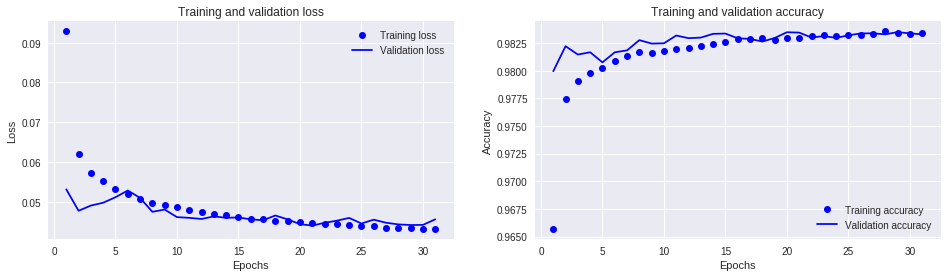

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 79s 2ms/step
([0.04410399658809434, 0.9838111525080186], 0.9836779196888988)
